# BLU06  - Exercise Notebook 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import warnings
idx = pd.IndexSlice
warnings.simplefilter(action='ignore', category=FutureWarning)   
from random import seed
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
import numpy as np
from sklearn.metrics import mean_squared_error
import math
from sklearn.ensemble import GradientBoostingRegressor
import itertools
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa import stattools
import hashlib # for grading purposes
from sklearn.model_selection import ParameterGrid

from pandas.plotting import lag_plot
plt.rcParams['figure.figsize'] = (12, 4)

from utils import *

%matplotlib inline

# Let's predict wind power production!

In [2]:
df = pd.read_csv('data/wind_power.csv')
df['date'] = pd.to_datetime(df['date'])
df = df.set_index('date')
df = df.sort_index()

##### Plot the series to get an idea of what's going on

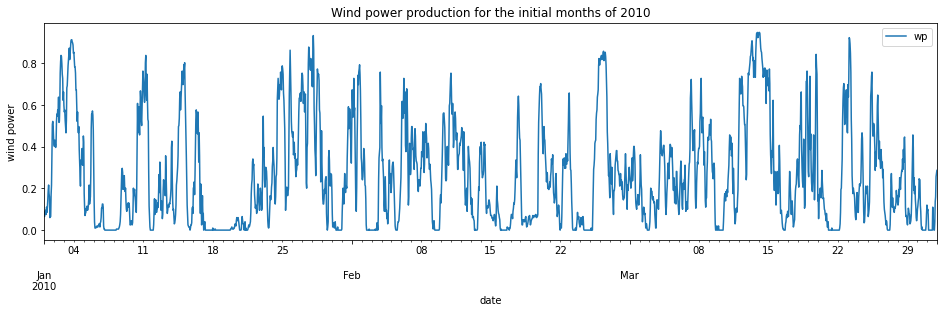

In [3]:
df.plot(figsize=(16, 4));
plt.ylabel('wind power')
plt.title('Wind power production for the initial months of 2010')
plt.show()

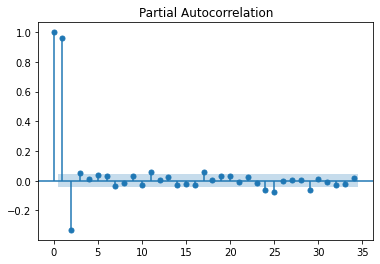

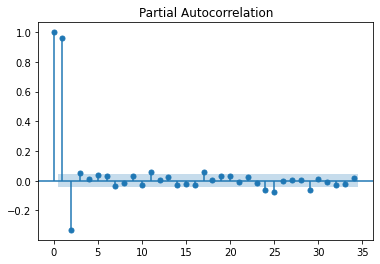

In [4]:
plot_pacf(df)

### Q1: Formulate it as time series one-step-ahead prediction

### Q1.1 Create the target, the relevant lags and drop the missing values.

In [5]:
df.isna().sum()

wp    0
dtype: int64

In [6]:
# Note: By relevant lags we expect you to assume the top 3 lags from the PACF (including negatively correlated ones).
# Remember from the previous BLU to look at the PACF you only need to run plot_pacf(df)

#(2134, 5)

index = pd.date_range(df.index.min(), df.index.max(), freq='H')

df_features = df.copy().reindex(index)

df_features['lag_a'] = df['wp'].shift(1)
df_features['lag_b'] = df['wp'].shift(2)
df_features['lag_c'] = df['wp'].shift(25)
df_features['target'] = df['wp'].shift(-1)

last_period = df_features.iloc[-1]
df_features = df_features.loc[df_features.index < last_period.name]

df_features = df_features.dropna()

# YOUR CODE HERE

In [7]:
expected_hash = '6e7c3f337212b8e01b67b3d63a2597b35850076095277e4cd323c07a33d02b93'
assert hashlib.sha256(str(df_features.shape).encode()).hexdigest() == expected_hash

expected_hash = 'e5351d4cf12cd01d360938a341d09da9cf5728ac1902133344147fbcab933fdc'
assert hashlib.sha256(str(df_features.iloc[0]).encode()).hexdigest() == expected_hash

### Q1.2 Separate the training and test set. The test set consists of the last 24 values, while the training set consists of the rest.

In [8]:
# note: this is a very straightforward question. But you may think: "isn't this one-step-ahead forecasting? 
# Why does the test have 24 values" Well, basically this just means we are doing 24 one-step-ahead forecasts.
# This way we obtain a better estimate of how our one-step-ahead model would perform in the real world.

#idx = pd.IndexSlice
#max_store10 = chain.loc[idx['1-4-2016':'30-4-2016', 10], 'customers'].max()

df_train = df_features[:-24]
df_test =  df_features[-24:]

# YOUR CODE HERE


In [9]:
expected_hash = '4645890e7eab6608a2037bae3d98cba5a58ed02bf55ca030aa721ed1c68f7403'
assert hashlib.sha256(str(df_train.index[-1]).encode()).hexdigest() == expected_hash

expected_hash = '49a4f69687c306f42ebbc05f79ad78ab8c963cbe20e98fc11cb77629fa6b7259'
assert hashlib.sha256(str(df_test.index[0]).encode()).hexdigest() == expected_hash

### Q1.3 Fit a linear regression to the training set

In [10]:
df_train.head()

,wp,lag_a,lag_b,lag_c,target
2010-01-02 01:00:00,0.401,0.411,0.441,0.085,0.431
2010-01-02 02:00:00,0.431,0.401,0.411,0.065,0.416
2010-01-02 03:00:00,0.416,0.431,0.401,0.080,0.396
2010-01-02 04:00:00,0.396,0.416,0.431,0.095,0.411
2010-01-02 05:00:00,0.411,0.396,0.416,0.095,0.521


In [11]:
X_df_train = df_train.drop('target', axis=1)
y_df_train = df_train['target']

model = LinearRegression()
model.fit(X_df_train, y_df_train)

# YOUR CODE HERE

LinearRegression()

In [12]:
expected_hash = '1f7448e98bdb7d0ec574b34ef1478a0a170a96448be5ef3dfa3ba426fd2a4e9d'
assert hashlib.sha256(str(X_df_train.shape).encode()).hexdigest() == expected_hash

expected_hash = '0e39cad2ee7a31366699e40633f45b99f0211f1734d40dab9d2c5fb461ab7aa7'
assert hashlib.sha256(str(y_df_train.shape).encode()).hexdigest() == expected_hash

expected_hash = '2211e7e3e265cdb6e1337bbc7deac40ed9cd0c3203e70fded127c801e783b5f2'
assert hashlib.sha256(str(np.round(model.coef_,1)).encode()).hexdigest() == expected_hash

### Q1.4 Predict the test set and calculate the MAE

In [13]:
X_df_test = df_test.drop('target', axis=1)
y_df_test = df_test['target']

y_predict = model.predict(X_df_test)
test_mae = mean_absolute_error(y_df_test, y_predict)

# YOUR CODE HERE

In [14]:
expected_hash = '4b259a01aeaa99e670a865121f78c1d76f029cd5158b51c72089c0bd254d17a1'
assert hashlib.sha256(str(X_df_test.shape).encode()).hexdigest() == expected_hash

expected_hash = '46ff29167351b465ba887b52b52ebddfd407ee7c8781d11225ad285541d89be5'
assert hashlib.sha256(str(y_df_test.shape).encode()).hexdigest() == expected_hash

expected_hash = '64b1c7c2dc78c85eb25fc8ebbbe7b3f27095df61f7b0621c64be58a55a042cc6'
assert hashlib.sha256(str(np.round(test_mae,5)).encode()).hexdigest() == expected_hash

### Q2 Let's go into multi-step prediction!

### Q2.1 Separate into train, val and test. Test corresponds to the last 24 values and Val corresponds to the 24 steps before test.

In [15]:
df_multistep_train = df[:-48]
df_multistep_val = df[-48:-24]
df_multistep_test = df[-24:]

# YOUR CODE HERE

In [16]:
expected_hash = 'b9202ef2e8ac88d956f6a0fc0b5c83540a0568fc2a19b5941796f3b140d84419'
assert hashlib.sha256(str(df_multistep_train.shape).encode()).hexdigest() == expected_hash

expected_hash = '17511d2ef2dbcb5be2ccb6880d9c364c156770484a5cf8292dfe283ea2405125'
assert hashlib.sha256(str(df_multistep_val.shape).encode()).hexdigest() == expected_hash

expected_hash = '17511d2ef2dbcb5be2ccb6880d9c364c156770484a5cf8292dfe283ea2405125'
assert hashlib.sha256(str(df_multistep_test.shape).encode()).hexdigest() == expected_hash

### Q2.2 Let's test some hyperparameter optimization!

In [17]:
df_multistep_train.head()

,wp
date,
2010-01-01 00:00:00,0.085
2010-01-01 01:00:00,0.065
2010-01-01 02:00:00,0.080
2010-01-01 03:00:00,0.095
2010-01-01 04:00:00,0.095


In [18]:
%%time

# Create a parameter grid with the following conditions:
#    - Include the linear regression and gradient boosting regressor models. 
#      For the gradient boosting regressor use n_estimators=20 and random_state=10
#    - Test using 3 and 26 lags
#    - Test using 0 or 15 periods diffed
#    - Set the weekday, month and holidays to False. These shouldn't affect wind power.
#    - Don't use rollings.
# Use a for cycle to find the group of params that minimizes the MAE on the validation set.

# hint: to have no rollings in the predict_n_periods you should put an empty lists of lists in the param grid: [[]]


param_grid = {'model': [LinearRegression(), GradientBoostingRegressor(n_estimators=20, random_state=10)], # 
              'num_periods_lagged':[3], # 26
              'num_periods_diffed':[0], # 15
              'weekday':[False],
              'month':[False],
              'holidays': [False],
              'rolling' : [[]]
             }

grid = ParameterGrid(param_grid)

# for params in grid:
     # predictions =
    
min_error = -1
best_params = {}

for params in grid:
    predictions = predict_n_periods(series_=df_multistep_train, 
                      n_periods=24, 
                      model=params['model'], 
                      num_periods_lagged=params['num_periods_lagged'],
                      num_periods_diffed=params['num_periods_diffed'],
                      weekday=params['weekday'],
                      month=params['month'],
                      rolling=params['rolling'],
                      target="wp"
                    )

    error = mean_absolute_error(df_multistep_val,predictions)
    if min_error == -1 or error < min_error:
        min_error = error
        best_params = params


# Reorder dict

desired_order_list = ['weekday','rolling','num_periods_lagged','num_periods_diffed','month','model','holidays']
best_params = {k: best_params[k] for k in desired_order_list}
        
# YOUR CODE HERE

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

CPU times: user 1.18 s, sys: 30.2 ms, total: 1.21 s
Wall time: 1.2 s


In [19]:
best_params

{'weekday': False,
 'rolling': [],
 'num_periods_lagged': 3,
 'num_periods_diffed': 0,
 'month': False,
 'model': LinearRegression(),
 'holidays': False}

In [20]:
expected_hash = '0c7f50ff83b085cd342a206e2c60d557601bddd1f378de106098f9350640d61e'
assert hashlib.sha256(str(best_params['model']).encode()).hexdigest() == expected_hash

expected_hash = '4e07408562bedb8b60ce05c1decfe3ad16b72230967de01f640b7e4729b49fce'
assert hashlib.sha256(str(best_params['num_periods_lagged']).encode()).hexdigest() == expected_hash

expected_hash = '5feceb66ffc86f38d952786c6d696c79c2dbc239dd4e91b46729d73a27fb57e9'
assert hashlib.sha256(str(best_params['num_periods_diffed']).encode()).hexdigest() == expected_hash

expected_hash = '1eafc175324ea36dbf3d3b7887e3887739219034fb5e3a9fb62759d6e9262b09'
assert hashlib.sha256(str(best_params).encode()).hexdigest() == expected_hash

### Q2.3 Train a model with the best combination and predict the test set. Calculate the corresponding MAE.

In [21]:
# We expect you to train the final model with train and val together.

df_multistep_train_val = df_multistep_train = df[:-24]
predictions = predictions = predict_n_periods(series_=df_multistep_train, 
                      n_periods=24, 
                      model=best_params['model'], 
                      num_periods_lagged=best_params['num_periods_lagged'],
                      num_periods_diffed=best_params['num_periods_diffed'],
                      weekday=best_params['weekday'],
                      month=best_params['month'],
                      rolling=best_params['rolling'],
                      target="wp"
                    )
test_mae = mean_absolute_error(df_multistep_test,predictions)

# YOUR CODE HERE

  0%|          | 0/24 [00:00<?, ?it/s]

In [22]:
expected_hash = '389b9a7d9112bcd9a1b488224b030633d4e420fcabb1ebf9c839072046c2c4c4'
assert hashlib.sha256(str(np.round(test_mae,5)).encode()).hexdigest() == expected_hash

### Q3 Finally, we'll add exogenous features to improve model performance!

In [23]:
exog = pd.read_csv('data/wind_speed_forecast.csv')
exog['date'] = pd.to_datetime(exog['date'])
exog = exog.set_index('date')
exog = exog.sort_index()

### Q3.1 Add the exogenous feature to the dataset and the corresponding leads

In [24]:
# Remember you want to build a number of leads corresponding to the 24 values of the next day

df["exog"] = exog
df = build_exog_features(df, 24)

# YOUR CODE HERE

In [25]:
expected_hash = 'dc81d4b4ac58b278e08f7c97d999d52f0b6b2416fa6ee85c37371b65194b92e1'
assert hashlib.sha256(str(df.shape).encode()).hexdigest() == expected_hash

expected_hash = 'c958a8701a36c5c8de6af0e4be7643e2a11f603d1c7e08da1cbcc0717955b278'
assert hashlib.sha256(str(df).encode()).hexdigest() == expected_hash

### Q3.2 Separate into train, val and test. Test corresponds to the last 24 values and Val corresponds to the 24 steps before test.

In [26]:
df_multistep_train = df[:-48]
df_multistep_val = df[-48:-24]
df_multistep_test = df[-24:]

# YOUR CODE HERE

In [27]:
expected_hash = '2837155d68248a6d1b420e270ceed5dc0a593693ad57948e1fc4df01ecf97695'
assert hashlib.sha256(str(df_multistep_train.shape).encode()).hexdigest() == expected_hash

expected_hash = '87dc6044b1bf391af8f8cd3b7bc9022b8d2a4df90c38ca4b30cae58843788eb8'
assert hashlib.sha256(str(df_multistep_val.shape).encode()).hexdigest() == expected_hash

expected_hash = '87dc6044b1bf391af8f8cd3b7bc9022b8d2a4df90c38ca4b30cae58843788eb8'
assert hashlib.sha256(str(df_multistep_test.shape).encode()).hexdigest() == expected_hash

### Q3.3 Let's test some hyperparameter optimisation (again)!

In [28]:
%%time

# Create a parameter grid with the following conditions:
#    - Include the linear regression and gradient boosting regressor models. 
#      For the gradient boosting regressor use n_estimators=20 and random_state=10
#    - Test using 3 and 26 lags
#    - Set the periods diffed to 0
#    - Set the weekday, month and holidays to False. These shouldn't affect wind power.
#    - Don't use rollings.
# Use a for cycle to find the group of params that minimizes the MAE on the validation set.

# hint: This should be pretty much a copy paste from exercise 2.2. Remember that now our dataset has
#       exogenous features so we want to understand if the hyperparameter optimisation result changes.


param_grid = {'model': [LinearRegression(), GradientBoostingRegressor(n_estimators=20, random_state=10)], # 
              'num_periods_lagged':[3, 26],
              'num_periods_diffed':[0],
              'weekday':[False],
              'month':[False],
              'holidays': [False],
              'rolling' : [[]]
             }

grid = ParameterGrid(param_grid)

min_error = -1
best_params = {}

for params in grid:
    predictions = predict_n_periods(series_=df_multistep_train, 
                      n_periods=24, 
                      model=params['model'], 
                      num_periods_lagged=params['num_periods_lagged'],
                      num_periods_diffed=params['num_periods_diffed'],
                      weekday=params['weekday'],
                      month=params['month'],
                      rolling=params['rolling'],
                      target="wp"
                    )

    error = mean_absolute_error(df_multistep_val['wp'],predictions)
    
    if min_error == -1 or error < min_error:
        min_error = error
        best_params = params


# Reorder dict

desired_order_list = ['weekday','rolling','num_periods_lagged','num_periods_diffed','month','model','holidays']
best_params = {k: best_params[k] for k in desired_order_list}

# YOUR CODE HERE

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

CPU times: user 17.3 s, sys: 691 ms, total: 18 s
Wall time: 14.7 s


In [29]:
best_params

{'weekday': False,
 'rolling': [],
 'num_periods_lagged': 3,
 'num_periods_diffed': 0,
 'month': False,
 'model': GradientBoostingRegressor(n_estimators=20, random_state=10),
 'holidays': False}

In [30]:
expected_hash = '4a4e3897467aca700e8b7f6bad8af525326b1299498c701bc3313b8056750bbb'
assert hashlib.sha256(str(best_params['model']).encode()).hexdigest() == expected_hash

expected_hash = '4e07408562bedb8b60ce05c1decfe3ad16b72230967de01f640b7e4729b49fce'
assert hashlib.sha256(str(best_params['num_periods_lagged']).encode()).hexdigest() == expected_hash

expected_hash = '5feceb66ffc86f38d952786c6d696c79c2dbc239dd4e91b46729d73a27fb57e9'
assert hashlib.sha256(str(best_params['num_periods_diffed']).encode()).hexdigest() == expected_hash

expected_hash = '36ea53ab868bf8f53bf8cb79c37e4174c942c1c9a8fa847c8c9bb5dc338c057f'
assert hashlib.sha256(str(best_params).encode()).hexdigest() == expected_hash

### Q3.4 Train a model with the best combination and predict the test. Did the exogenous feature improve the MAE?

In [31]:
# We expect you to train the final model with train and val together.
df_multistep_train_val = df[:-24]
predictions = predict_n_periods(series_=df_multistep_train_val, 
                      n_periods=24, 
                      model=best_params['model'], 
                      num_periods_lagged=best_params['num_periods_lagged'],
                      num_periods_diffed=best_params['num_periods_diffed'],
                      weekday=best_params['weekday'],
                      month=best_params['month'],
                      rolling=best_params['rolling'],
                      target="wp"
                    )
test_mae = mean_absolute_error(df_multistep_test['wp'],predictions)

# hint: Again, this should be mostly a copy paste from the exercise 2.3

# YOUR CODE HERE

  0%|          | 0/24 [00:00<?, ?it/s]

In [32]:
expected_hash = '5b0c19587a858f320eda9f4a1e31017027fb7f5a970424aa7e00b6e38eeac273'
assert hashlib.sha256(str(np.round(test_mae,5)).encode()).hexdigest() == expected_hash